# Models Comparison for TinyML

In [1]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)
tasks = ["2Labels", "3Labels", "4Labels", "5Labels"]
# Change this to change subtask
taskIndex = 3

In [3]:
with open('data/X.pkl', 'rb') as f:
    X = pickle.load(f)

with open('data/y.pkl', 'rb') as f:
    y = pickle.load(f)

In [4]:
n_labels = 2 + taskIndex
samples = 100
X = X[:n_labels*samples]
y = y[:n_labels*samples]
labels = np.unique(y)

In [5]:
classes = np.unique(y).tolist()
for i in range(len(classes)):
    y = np.where(y==classes[i], i, y)

In [6]:
y = np.array([int(el) for el in y])
print(y)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
print(X_test.shape)
print(y_test.shape)


(100, 42)
(100,)


In [8]:
y_test

array([2, 3, 2, 0, 0, 3, 1, 2, 3, 4, 4, 1, 1, 1, 4, 1, 3, 0, 4, 1, 1, 3,
       1, 2, 3, 0, 2, 1, 0, 4, 4, 4, 4, 3, 4, 2, 0, 2, 1, 3, 0, 3, 2, 4,
       2, 0, 4, 0, 1, 1, 0, 3, 0, 2, 0, 2, 4, 4, 0, 0, 3, 2, 3, 3, 0, 2,
       2, 3, 1, 0, 3, 2, 4, 2, 3, 4, 4, 3, 0, 4, 1, 1, 1, 0, 0, 2, 1, 4,
       3, 3, 0, 4, 4, 1, 1, 2, 1, 3, 2, 2])

## Model Spotting

In [9]:
# Test options and evaluation metric
num_folds = 5
seed = 42
scoring = 'f1_macro'

In [10]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.99, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100, 
                                                           max_features=5, criterion='gini', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1)))


In [11]:
# Cross Validation
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,85 0,05
LR - 0,89 0,02
CART - 0,77 0,08
SVC - 0,93 0,03
RF - 0,89 0,03


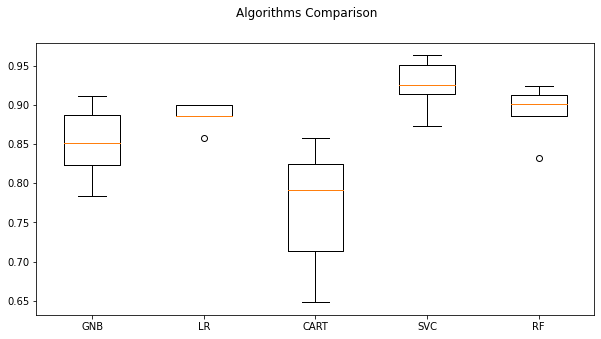

In [12]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

## Valutazione modelli sul Test Set

In [13]:
def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2] if taskIndex > 1 else row[-3]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = labels[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[taskIndex] + "/classificationReports/" +'report' + model_name +  '.csv', index = False)
    
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    #classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.68      0.75      0.71        20
           2       0.80      0.80      0.80        20
           3       1.00      0.80      0.89        20
           4       0.86      0.95      0.90        20

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.94      0.80      0.86        20
           2       0.74      0.85      0.79        20
           3       0.89      0.80      0.84        20
           4       0.86      0.95      0.90        20

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87   

# Neural Network

In [14]:
#Hyperparameters of NN
EPOCHS = 500 
BATCH_SIZE = 7
learn_rate = 0.001
nodes = 256
def getNetwork():
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dropout(0.25))    
    model.add(layers.Dense(nodes, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=learn_rate)
    # SGB
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

## Cross Validation NN

In [15]:
num_folds = 5

kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 42)                1806      
_________________________________________________________________
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               11008     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 14,099
Trainable params: 14,099
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
46/46 [==============================] - 0s 412us/step - loss: 1.5987 - accuracy: 0.2656
Epoch 2/500
46

46/46 [==============================] - 0s 424us/step - loss: 0.1588 - accuracy: 0.9219
Epoch 72/500
46/46 [==============================] - 0s 400us/step - loss: 0.1897 - accuracy: 0.9187
Epoch 73/500
46/46 [==============================] - 0s 406us/step - loss: 0.1634 - accuracy: 0.9406
Epoch 74/500
46/46 [==============================] - 0s 398us/step - loss: 0.1654 - accuracy: 0.9406
Epoch 75/500
46/46 [==============================] - 0s 412us/step - loss: 0.1368 - accuracy: 0.9469
Epoch 76/500
46/46 [==============================] - 0s 405us/step - loss: 0.1329 - accuracy: 0.9406
Epoch 77/500
46/46 [==============================] - 0s 421us/step - loss: 0.1408 - accuracy: 0.9500
Epoch 78/500
46/46 [==============================] - 0s 398us/step - loss: 0.1595 - accuracy: 0.9469
Epoch 79/500
46/46 [==============================] - 0s 409us/step - loss: 0.1825 - accuracy: 0.9281
Epoch 80/500
46/46 [==============================] - 0s 407us/step - loss: 0.1235 - accuracy: 

Epoch 151/500
46/46 [==============================] - 0s 405us/step - loss: 0.0843 - accuracy: 0.9688
Epoch 152/500
46/46 [==============================] - 0s 405us/step - loss: 0.0828 - accuracy: 0.9656
Epoch 153/500
46/46 [==============================] - 0s 421us/step - loss: 0.0899 - accuracy: 0.9688
Epoch 154/500
46/46 [==============================] - 0s 415us/step - loss: 0.1199 - accuracy: 0.9500
Epoch 155/500
46/46 [==============================] - 0s 400us/step - loss: 0.0802 - accuracy: 0.9750
Epoch 156/500
46/46 [==============================] - 0s 403us/step - loss: 0.0697 - accuracy: 0.9656
Epoch 157/500
46/46 [==============================] - 0s 411us/step - loss: 0.0587 - accuracy: 0.9812
Epoch 158/500
46/46 [==============================] - 0s 406us/step - loss: 0.0733 - accuracy: 0.9812
Epoch 159/500
46/46 [==============================] - 0s 407us/step - loss: 0.1061 - accuracy: 0.9688
Epoch 160/500
46/46 [==============================] - 0s 402us/step - lo

46/46 [==============================] - 0s 421us/step - loss: 0.0374 - accuracy: 0.9844
Epoch 231/500
46/46 [==============================] - 0s 407us/step - loss: 0.0899 - accuracy: 0.9688
Epoch 232/500
46/46 [==============================] - 0s 396us/step - loss: 0.0535 - accuracy: 0.9844
Epoch 233/500
46/46 [==============================] - 0s 409us/step - loss: 0.0576 - accuracy: 0.9812
Epoch 234/500
46/46 [==============================] - 0s 397us/step - loss: 0.0523 - accuracy: 0.9875
Epoch 235/500
46/46 [==============================] - 0s 398us/step - loss: 0.0571 - accuracy: 0.9781
Epoch 236/500
46/46 [==============================] - 0s 404us/step - loss: 0.0368 - accuracy: 0.9875
Epoch 237/500
46/46 [==============================] - 0s 408us/step - loss: 0.0554 - accuracy: 0.9781
Epoch 238/500
46/46 [==============================] - 0s 405us/step - loss: 0.0807 - accuracy: 0.9688
Epoch 239/500
46/46 [==============================] - 0s 405us/step - loss: 0.0508 - a

46/46 [==============================] - 0s 409us/step - loss: 0.0337 - accuracy: 0.9844
Epoch 310/500
46/46 [==============================] - 0s 406us/step - loss: 0.0565 - accuracy: 0.9719
Epoch 311/500
46/46 [==============================] - 0s 416us/step - loss: 0.0583 - accuracy: 0.9781
Epoch 312/500
46/46 [==============================] - 0s 411us/step - loss: 0.0418 - accuracy: 0.9844
Epoch 313/500
46/46 [==============================] - 0s 395us/step - loss: 0.0612 - accuracy: 0.9812
Epoch 314/500
46/46 [==============================] - 0s 398us/step - loss: 0.0196 - accuracy: 0.9937
Epoch 315/500
46/46 [==============================] - 0s 401us/step - loss: 0.0733 - accuracy: 0.9719
Epoch 316/500
46/46 [==============================] - 0s 417us/step - loss: 0.0850 - accuracy: 0.9625
Epoch 317/500
46/46 [==============================] - 0s 403us/step - loss: 0.0261 - accuracy: 1.0000
Epoch 318/500
46/46 [==============================] - 0s 408us/step - loss: 0.0919 - a

46/46 [==============================] - 0s 405us/step - loss: 0.0897 - accuracy: 0.9719
Epoch 389/500
46/46 [==============================] - 0s 419us/step - loss: 0.0256 - accuracy: 0.9875
Epoch 390/500
46/46 [==============================] - 0s 410us/step - loss: 0.0638 - accuracy: 0.9781
Epoch 391/500
46/46 [==============================] - 0s 410us/step - loss: 0.0536 - accuracy: 0.9781
Epoch 392/500
46/46 [==============================] - 0s 407us/step - loss: 0.0345 - accuracy: 0.9844
Epoch 393/500
46/46 [==============================] - 0s 409us/step - loss: 0.0311 - accuracy: 0.9937
Epoch 394/500
46/46 [==============================] - 0s 414us/step - loss: 0.0146 - accuracy: 0.9969
Epoch 395/500
46/46 [==============================] - 0s 408us/step - loss: 0.0492 - accuracy: 0.9875
Epoch 396/500
46/46 [==============================] - 0s 411us/step - loss: 0.0549 - accuracy: 0.9812
Epoch 397/500
46/46 [==============================] - 0s 423us/step - loss: 0.0481 - a

46/46 [==============================] - 0s 401us/step - loss: 0.0764 - accuracy: 0.9719
Epoch 468/500
46/46 [==============================] - 0s 409us/step - loss: 0.0425 - accuracy: 0.9844
Epoch 469/500
46/46 [==============================] - 0s 400us/step - loss: 0.0308 - accuracy: 0.9875
Epoch 470/500
46/46 [==============================] - 0s 411us/step - loss: 0.0316 - accuracy: 0.9906
Epoch 471/500
46/46 [==============================] - 0s 407us/step - loss: 0.0365 - accuracy: 0.9812
Epoch 472/500
46/46 [==============================] - 0s 432us/step - loss: 0.0319 - accuracy: 0.9906
Epoch 473/500
46/46 [==============================] - 0s 404us/step - loss: 0.0323 - accuracy: 0.9875
Epoch 474/500
46/46 [==============================] - 0s 410us/step - loss: 0.0274 - accuracy: 0.9906
Epoch 475/500
46/46 [==============================] - 0s 408us/step - loss: 0.0315 - accuracy: 0.9875
Epoch 476/500
46/46 [==============================] - 0s 410us/step - loss: 0.0244 - a

46/46 [==============================] - 0s 408us/step - loss: 0.2656 - accuracy: 0.8813
Epoch 38/500
46/46 [==============================] - 0s 415us/step - loss: 0.2391 - accuracy: 0.9156
Epoch 39/500
46/46 [==============================] - 0s 396us/step - loss: 0.2688 - accuracy: 0.8969
Epoch 40/500
46/46 [==============================] - 0s 413us/step - loss: 0.2583 - accuracy: 0.9000
Epoch 41/500
46/46 [==============================] - 0s 400us/step - loss: 0.2678 - accuracy: 0.9125
Epoch 42/500
46/46 [==============================] - 0s 404us/step - loss: 0.2172 - accuracy: 0.9219
Epoch 43/500
46/46 [==============================] - 0s 410us/step - loss: 0.2358 - accuracy: 0.9281
Epoch 44/500
46/46 [==============================] - 0s 404us/step - loss: 0.2170 - accuracy: 0.9312
Epoch 45/500
46/46 [==============================] - 0s 405us/step - loss: 0.2111 - accuracy: 0.9156
Epoch 46/500
46/46 [==============================] - 0s 403us/step - loss: 0.2128 - accuracy: 

46/46 [==============================] - 0s 395us/step - loss: 0.0974 - accuracy: 0.9594
Epoch 118/500
46/46 [==============================] - 0s 417us/step - loss: 0.1392 - accuracy: 0.9469
Epoch 119/500
46/46 [==============================] - 0s 419us/step - loss: 0.1031 - accuracy: 0.9688
Epoch 120/500
46/46 [==============================] - 0s 436us/step - loss: 0.0702 - accuracy: 0.9812
Epoch 121/500
46/46 [==============================] - 0s 427us/step - loss: 0.0606 - accuracy: 0.9719
Epoch 122/500
46/46 [==============================] - 0s 412us/step - loss: 0.0830 - accuracy: 0.9688
Epoch 123/500
46/46 [==============================] - 0s 405us/step - loss: 0.1259 - accuracy: 0.9563
Epoch 124/500
46/46 [==============================] - 0s 422us/step - loss: 0.0806 - accuracy: 0.9781
Epoch 125/500
46/46 [==============================] - 0s 426us/step - loss: 0.0812 - accuracy: 0.9656
Epoch 126/500
46/46 [==============================] - 0s 405us/step - loss: 0.0952 - a

46/46 [==============================] - 0s 411us/step - loss: 0.0785 - accuracy: 0.9531
Epoch 197/500
46/46 [==============================] - 0s 434us/step - loss: 0.0582 - accuracy: 0.9781
Epoch 198/500
46/46 [==============================] - 0s 426us/step - loss: 0.0509 - accuracy: 0.9906
Epoch 199/500
46/46 [==============================] - 0s 408us/step - loss: 0.0522 - accuracy: 0.9781
Epoch 200/500
46/46 [==============================] - 0s 405us/step - loss: 0.0583 - accuracy: 0.9781
Epoch 201/500
46/46 [==============================] - 0s 406us/step - loss: 0.0640 - accuracy: 0.9812
Epoch 202/500
46/46 [==============================] - 0s 420us/step - loss: 0.0389 - accuracy: 0.9906
Epoch 203/500
46/46 [==============================] - 0s 414us/step - loss: 0.0778 - accuracy: 0.9688
Epoch 204/500
46/46 [==============================] - 0s 411us/step - loss: 0.0596 - accuracy: 0.9781
Epoch 205/500
46/46 [==============================] - 0s 420us/step - loss: 0.0406 - a

46/46 [==============================] - 0s 404us/step - loss: 0.0301 - accuracy: 0.9875
Epoch 276/500
46/46 [==============================] - 0s 431us/step - loss: 0.0420 - accuracy: 0.9875
Epoch 277/500
46/46 [==============================] - 0s 410us/step - loss: 0.0141 - accuracy: 1.0000
Epoch 278/500
46/46 [==============================] - 0s 404us/step - loss: 0.0188 - accuracy: 0.9937
Epoch 279/500
46/46 [==============================] - 0s 405us/step - loss: 0.0216 - accuracy: 0.9969
Epoch 280/500
46/46 [==============================] - 0s 421us/step - loss: 0.0390 - accuracy: 0.9812
Epoch 281/500
46/46 [==============================] - 0s 413us/step - loss: 0.0575 - accuracy: 0.9875
Epoch 282/500
46/46 [==============================] - 0s 416us/step - loss: 0.0647 - accuracy: 0.9781
Epoch 283/500
46/46 [==============================] - 0s 409us/step - loss: 0.0701 - accuracy: 0.9750
Epoch 284/500
46/46 [==============================] - 0s 418us/step - loss: 0.0290 - a

46/46 [==============================] - 0s 422us/step - loss: 0.0308 - accuracy: 0.9906
Epoch 355/500
46/46 [==============================] - 0s 405us/step - loss: 0.0447 - accuracy: 0.9844
Epoch 356/500
46/46 [==============================] - 0s 409us/step - loss: 0.0167 - accuracy: 0.9969
Epoch 357/500
46/46 [==============================] - 0s 421us/step - loss: 0.0093 - accuracy: 0.9969
Epoch 358/500
46/46 [==============================] - 0s 421us/step - loss: 0.0493 - accuracy: 0.9750
Epoch 359/500
46/46 [==============================] - 0s 402us/step - loss: 0.0163 - accuracy: 0.9969
Epoch 360/500
46/46 [==============================] - 0s 412us/step - loss: 0.0261 - accuracy: 0.9906
Epoch 361/500
46/46 [==============================] - 0s 403us/step - loss: 0.0194 - accuracy: 0.9937
Epoch 362/500
46/46 [==============================] - 0s 416us/step - loss: 0.0173 - accuracy: 0.9937
Epoch 363/500
46/46 [==============================] - 0s 412us/step - loss: 0.0394 - a

46/46 [==============================] - 0s 413us/step - loss: 0.0488 - accuracy: 0.9906
Epoch 434/500
46/46 [==============================] - 0s 408us/step - loss: 0.0613 - accuracy: 0.9812
Epoch 435/500
46/46 [==============================] - 0s 417us/step - loss: 0.0411 - accuracy: 0.9906
Epoch 436/500
46/46 [==============================] - 0s 411us/step - loss: 0.0529 - accuracy: 0.9812
Epoch 437/500
46/46 [==============================] - 0s 407us/step - loss: 0.0215 - accuracy: 0.9937
Epoch 438/500
46/46 [==============================] - 0s 414us/step - loss: 0.0222 - accuracy: 0.9875
Epoch 439/500
46/46 [==============================] - 0s 410us/step - loss: 0.0181 - accuracy: 0.9906
Epoch 440/500
46/46 [==============================] - 0s 422us/step - loss: 0.0182 - accuracy: 0.9937
Epoch 441/500
46/46 [==============================] - 0s 410us/step - loss: 0.0243 - accuracy: 0.9937
Epoch 442/500
46/46 [==============================] - 0s 402us/step - loss: 0.0221 - a

46/46 [==============================] - 0s 410us/step - loss: 1.4614 - accuracy: 0.4000
Epoch 3/500
46/46 [==============================] - 0s 415us/step - loss: 1.2879 - accuracy: 0.4750
Epoch 4/500
46/46 [==============================] - 0s 417us/step - loss: 1.1065 - accuracy: 0.5594
Epoch 5/500
46/46 [==============================] - 0s 414us/step - loss: 0.9593 - accuracy: 0.6594
Epoch 6/500
46/46 [==============================] - 0s 400us/step - loss: 0.9619 - accuracy: 0.5719
Epoch 7/500
46/46 [==============================] - 0s 407us/step - loss: 0.8492 - accuracy: 0.6313
Epoch 8/500
46/46 [==============================] - 0s 398us/step - loss: 0.7723 - accuracy: 0.7188
Epoch 9/500
46/46 [==============================] - 0s 420us/step - loss: 0.7057 - accuracy: 0.7250
Epoch 10/500
46/46 [==============================] - 0s 418us/step - loss: 0.6609 - accuracy: 0.7437
Epoch 11/500
46/46 [==============================] - 0s 404us/step - loss: 0.6274 - accuracy: 0.7625


46/46 [==============================] - 0s 413us/step - loss: 0.1082 - accuracy: 0.9625
Epoch 83/500
46/46 [==============================] - 0s 421us/step - loss: 0.1116 - accuracy: 0.9594
Epoch 84/500
46/46 [==============================] - 0s 417us/step - loss: 0.1339 - accuracy: 0.9500
Epoch 85/500
46/46 [==============================] - 0s 420us/step - loss: 0.1034 - accuracy: 0.9656
Epoch 86/500
46/46 [==============================] - 0s 408us/step - loss: 0.0936 - accuracy: 0.9656
Epoch 87/500
46/46 [==============================] - 0s 439us/step - loss: 0.1270 - accuracy: 0.9531
Epoch 88/500
46/46 [==============================] - 0s 407us/step - loss: 0.1312 - accuracy: 0.9500
Epoch 89/500
46/46 [==============================] - 0s 414us/step - loss: 0.0992 - accuracy: 0.9594
Epoch 90/500
46/46 [==============================] - 0s 409us/step - loss: 0.1014 - accuracy: 0.9625
Epoch 91/500
46/46 [==============================] - 0s 442us/step - loss: 0.1106 - accuracy: 

46/46 [==============================] - 0s 427us/step - loss: 0.0866 - accuracy: 0.9688
Epoch 162/500
46/46 [==============================] - 0s 405us/step - loss: 0.0607 - accuracy: 0.9844
Epoch 163/500
46/46 [==============================] - 0s 413us/step - loss: 0.0347 - accuracy: 0.9906
Epoch 164/500
46/46 [==============================] - 0s 418us/step - loss: 0.0543 - accuracy: 0.9781
Epoch 165/500
46/46 [==============================] - 0s 405us/step - loss: 0.1201 - accuracy: 0.9594
Epoch 166/500
46/46 [==============================] - 0s 415us/step - loss: 0.1009 - accuracy: 0.9625
Epoch 167/500
46/46 [==============================] - 0s 397us/step - loss: 0.0437 - accuracy: 0.9875
Epoch 168/500
46/46 [==============================] - 0s 425us/step - loss: 0.0863 - accuracy: 0.9750
Epoch 169/500
46/46 [==============================] - 0s 413us/step - loss: 0.0411 - accuracy: 0.9875
Epoch 170/500
46/46 [==============================] - 0s 413us/step - loss: 0.0682 - a

46/46 [==============================] - 0s 421us/step - loss: 0.0532 - accuracy: 0.9875
Epoch 241/500
46/46 [==============================] - 0s 403us/step - loss: 0.0337 - accuracy: 0.9844
Epoch 242/500
46/46 [==============================] - 0s 397us/step - loss: 0.0608 - accuracy: 0.9812
Epoch 243/500
46/46 [==============================] - 0s 424us/step - loss: 0.0401 - accuracy: 0.9812
Epoch 244/500
46/46 [==============================] - 0s 406us/step - loss: 0.0539 - accuracy: 0.9719
Epoch 245/500
46/46 [==============================] - 0s 409us/step - loss: 0.0462 - accuracy: 0.9812
Epoch 246/500
46/46 [==============================] - 0s 400us/step - loss: 0.0672 - accuracy: 0.9656
Epoch 247/500
46/46 [==============================] - 0s 399us/step - loss: 0.0361 - accuracy: 0.9812
Epoch 248/500
46/46 [==============================] - 0s 412us/step - loss: 0.1035 - accuracy: 0.9625
Epoch 249/500
46/46 [==============================] - 0s 398us/step - loss: 0.1091 - a

46/46 [==============================] - 0s 410us/step - loss: 0.0354 - accuracy: 0.9844
Epoch 320/500
46/46 [==============================] - 0s 411us/step - loss: 0.0247 - accuracy: 0.9937
Epoch 321/500
46/46 [==============================] - 0s 421us/step - loss: 0.0191 - accuracy: 0.9937
Epoch 322/500
46/46 [==============================] - 0s 397us/step - loss: 0.0408 - accuracy: 0.9875
Epoch 323/500
46/46 [==============================] - 0s 403us/step - loss: 0.0458 - accuracy: 0.9812
Epoch 324/500
46/46 [==============================] - 0s 413us/step - loss: 0.0388 - accuracy: 0.9844
Epoch 325/500
46/46 [==============================] - 0s 414us/step - loss: 0.0335 - accuracy: 0.9844
Epoch 326/500
46/46 [==============================] - 0s 402us/step - loss: 0.0385 - accuracy: 0.9875
Epoch 327/500
46/46 [==============================] - 0s 424us/step - loss: 0.0122 - accuracy: 0.9969
Epoch 328/500
46/46 [==============================] - 0s 405us/step - loss: 0.0223 - a

46/46 [==============================] - 0s 408us/step - loss: 0.0377 - accuracy: 0.9875
Epoch 399/500
46/46 [==============================] - 0s 417us/step - loss: 0.0320 - accuracy: 0.9812
Epoch 400/500
46/46 [==============================] - 0s 406us/step - loss: 0.0249 - accuracy: 0.9937
Epoch 401/500
46/46 [==============================] - 0s 415us/step - loss: 0.0361 - accuracy: 0.9875
Epoch 402/500
46/46 [==============================] - 0s 406us/step - loss: 0.0594 - accuracy: 0.9844
Epoch 403/500
46/46 [==============================] - 0s 408us/step - loss: 0.0238 - accuracy: 0.9937
Epoch 404/500
46/46 [==============================] - 0s 412us/step - loss: 0.0191 - accuracy: 0.9906
Epoch 405/500
46/46 [==============================] - 0s 444us/step - loss: 0.0196 - accuracy: 0.9906
Epoch 406/500
46/46 [==============================] - 0s 417us/step - loss: 0.0614 - accuracy: 0.9719
Epoch 407/500
46/46 [==============================] - 0s 399us/step - loss: 0.0169 - a

46/46 [==============================] - 0s 404us/step - loss: 0.0537 - accuracy: 0.9812
Epoch 478/500
46/46 [==============================] - 0s 425us/step - loss: 0.0351 - accuracy: 0.9812
Epoch 479/500
46/46 [==============================] - 0s 402us/step - loss: 0.0268 - accuracy: 0.9906
Epoch 480/500
46/46 [==============================] - 0s 401us/step - loss: 0.0255 - accuracy: 0.9906
Epoch 481/500
46/46 [==============================] - 0s 421us/step - loss: 0.0757 - accuracy: 0.9812
Epoch 482/500
46/46 [==============================] - 0s 408us/step - loss: 0.0502 - accuracy: 0.9750
Epoch 483/500
46/46 [==============================] - 0s 404us/step - loss: 0.0193 - accuracy: 0.9937
Epoch 484/500
46/46 [==============================] - 0s 409us/step - loss: 0.0232 - accuracy: 0.9937
Epoch 485/500
46/46 [==============================] - 0s 410us/step - loss: 0.0094 - accuracy: 1.0000
Epoch 486/500
46/46 [==============================] - 0s 420us/step - loss: 0.0141 - a

46/46 [==============================] - 0s 416us/step - loss: 0.3134 - accuracy: 0.8687
Epoch 48/500
46/46 [==============================] - 0s 417us/step - loss: 0.3047 - accuracy: 0.8844
Epoch 49/500
46/46 [==============================] - 0s 409us/step - loss: 0.2888 - accuracy: 0.8938
Epoch 50/500
46/46 [==============================] - 0s 399us/step - loss: 0.3023 - accuracy: 0.8656
Epoch 51/500
46/46 [==============================] - 0s 403us/step - loss: 0.3040 - accuracy: 0.8719
Epoch 52/500
46/46 [==============================] - 0s 430us/step - loss: 0.2692 - accuracy: 0.8906
Epoch 53/500
46/46 [==============================] - 0s 409us/step - loss: 0.3087 - accuracy: 0.8781
Epoch 54/500
46/46 [==============================] - 0s 408us/step - loss: 0.2813 - accuracy: 0.8938
Epoch 55/500
46/46 [==============================] - 0s 409us/step - loss: 0.2844 - accuracy: 0.8781
Epoch 56/500
46/46 [==============================] - 0s 432us/step - loss: 0.2823 - accuracy: 

46/46 [==============================] - 0s 414us/step - loss: 0.1699 - accuracy: 0.9375
Epoch 128/500
46/46 [==============================] - 0s 422us/step - loss: 0.1344 - accuracy: 0.9438
Epoch 129/500
46/46 [==============================] - 0s 403us/step - loss: 0.1254 - accuracy: 0.9344
Epoch 130/500
46/46 [==============================] - 0s 442us/step - loss: 0.1247 - accuracy: 0.9563
Epoch 131/500
46/46 [==============================] - 0s 408us/step - loss: 0.1322 - accuracy: 0.9531
Epoch 132/500
46/46 [==============================] - 0s 417us/step - loss: 0.0879 - accuracy: 0.9719
Epoch 133/500
46/46 [==============================] - 0s 415us/step - loss: 0.1401 - accuracy: 0.9438
Epoch 134/500
46/46 [==============================] - 0s 422us/step - loss: 0.0971 - accuracy: 0.9750
Epoch 135/500
46/46 [==============================] - 0s 421us/step - loss: 0.1134 - accuracy: 0.9625
Epoch 136/500
46/46 [==============================] - 0s 424us/step - loss: 0.1390 - a

46/46 [==============================] - 0s 420us/step - loss: 0.0639 - accuracy: 0.9719
Epoch 207/500
46/46 [==============================] - 0s 419us/step - loss: 0.1041 - accuracy: 0.9563
Epoch 208/500
46/46 [==============================] - 0s 433us/step - loss: 0.0761 - accuracy: 0.9656
Epoch 209/500
46/46 [==============================] - 0s 419us/step - loss: 0.1062 - accuracy: 0.9625
Epoch 210/500
46/46 [==============================] - 0s 410us/step - loss: 0.0695 - accuracy: 0.9812
Epoch 211/500
46/46 [==============================] - 0s 415us/step - loss: 0.0964 - accuracy: 0.9719
Epoch 212/500
46/46 [==============================] - 0s 424us/step - loss: 0.0837 - accuracy: 0.9656
Epoch 213/500
46/46 [==============================] - 0s 407us/step - loss: 0.0816 - accuracy: 0.9750
Epoch 214/500
46/46 [==============================] - 0s 404us/step - loss: 0.0628 - accuracy: 0.9844
Epoch 215/500
46/46 [==============================] - 0s 424us/step - loss: 0.0947 - a

46/46 [==============================] - 0s 406us/step - loss: 0.0644 - accuracy: 0.9844
Epoch 286/500
46/46 [==============================] - 0s 396us/step - loss: 0.0494 - accuracy: 0.9781
Epoch 287/500
46/46 [==============================] - 0s 406us/step - loss: 0.0488 - accuracy: 0.9781
Epoch 288/500
46/46 [==============================] - 0s 401us/step - loss: 0.0707 - accuracy: 0.9812
Epoch 289/500
46/46 [==============================] - 0s 409us/step - loss: 0.0691 - accuracy: 0.9781
Epoch 290/500
46/46 [==============================] - 0s 401us/step - loss: 0.0375 - accuracy: 0.9875
Epoch 291/500
46/46 [==============================] - 0s 406us/step - loss: 0.1038 - accuracy: 0.9594
Epoch 292/500
46/46 [==============================] - 0s 402us/step - loss: 0.0524 - accuracy: 0.9812
Epoch 293/500
46/46 [==============================] - 0s 402us/step - loss: 0.0705 - accuracy: 0.9781
Epoch 294/500
46/46 [==============================] - 0s 406us/step - loss: 0.0710 - a

46/46 [==============================] - 0s 400us/step - loss: 0.0702 - accuracy: 0.9844
Epoch 365/500
46/46 [==============================] - 0s 395us/step - loss: 0.0492 - accuracy: 0.9812
Epoch 366/500
46/46 [==============================] - 0s 392us/step - loss: 0.0381 - accuracy: 0.9937
Epoch 367/500
46/46 [==============================] - 0s 396us/step - loss: 0.0443 - accuracy: 0.9844
Epoch 368/500
46/46 [==============================] - 0s 411us/step - loss: 0.0506 - accuracy: 0.9875
Epoch 369/500
46/46 [==============================] - 0s 405us/step - loss: 0.0668 - accuracy: 0.9719
Epoch 370/500
46/46 [==============================] - 0s 411us/step - loss: 0.0833 - accuracy: 0.9750
Epoch 371/500
46/46 [==============================] - 0s 403us/step - loss: 0.0621 - accuracy: 0.9781
Epoch 372/500
46/46 [==============================] - 0s 398us/step - loss: 0.1123 - accuracy: 0.9688
Epoch 373/500
46/46 [==============================] - 0s 405us/step - loss: 0.0367 - a

46/46 [==============================] - 0s 403us/step - loss: 0.0444 - accuracy: 0.9906
Epoch 444/500
46/46 [==============================] - 0s 397us/step - loss: 0.0354 - accuracy: 0.9844
Epoch 445/500
46/46 [==============================] - 0s 407us/step - loss: 0.0957 - accuracy: 0.9719
Epoch 446/500
46/46 [==============================] - 0s 411us/step - loss: 0.0492 - accuracy: 0.9875
Epoch 447/500
46/46 [==============================] - 0s 402us/step - loss: 0.0537 - accuracy: 0.9781
Epoch 448/500
46/46 [==============================] - 0s 399us/step - loss: 0.0434 - accuracy: 0.9844
Epoch 449/500
46/46 [==============================] - 0s 395us/step - loss: 0.0724 - accuracy: 0.9688
Epoch 450/500
46/46 [==============================] - 0s 412us/step - loss: 0.0693 - accuracy: 0.9781
Epoch 451/500
46/46 [==============================] - 0s 406us/step - loss: 0.0429 - accuracy: 0.9844
Epoch 452/500
46/46 [==============================] - 0s 400us/step - loss: 0.0695 - a

46/46 [==============================] - 0s 403us/step - loss: 0.5967 - accuracy: 0.7594
Epoch 14/500
46/46 [==============================] - 0s 393us/step - loss: 0.5034 - accuracy: 0.8156
Epoch 15/500
46/46 [==============================] - 0s 402us/step - loss: 0.4845 - accuracy: 0.8094
Epoch 16/500
46/46 [==============================] - 0s 406us/step - loss: 0.4898 - accuracy: 0.8031
Epoch 17/500
46/46 [==============================] - 0s 411us/step - loss: 0.4723 - accuracy: 0.8062
Epoch 18/500
46/46 [==============================] - 0s 405us/step - loss: 0.4644 - accuracy: 0.8000
Epoch 19/500
46/46 [==============================] - 0s 410us/step - loss: 0.4550 - accuracy: 0.8250
Epoch 20/500
46/46 [==============================] - 0s 402us/step - loss: 0.4275 - accuracy: 0.8344
Epoch 21/500
46/46 [==============================] - 0s 403us/step - loss: 0.3712 - accuracy: 0.8406
Epoch 22/500
46/46 [==============================] - 0s 403us/step - loss: 0.4348 - accuracy: 

46/46 [==============================] - 0s 432us/step - loss: 0.1189 - accuracy: 0.9625
Epoch 94/500
46/46 [==============================] - 0s 414us/step - loss: 0.1097 - accuracy: 0.9563
Epoch 95/500
46/46 [==============================] - 0s 424us/step - loss: 0.1223 - accuracy: 0.9563
Epoch 96/500
46/46 [==============================] - 0s 422us/step - loss: 0.0920 - accuracy: 0.9719
Epoch 97/500
46/46 [==============================] - 0s 426us/step - loss: 0.1263 - accuracy: 0.9531
Epoch 98/500
46/46 [==============================] - 0s 420us/step - loss: 0.1280 - accuracy: 0.9469
Epoch 99/500
46/46 [==============================] - 0s 424us/step - loss: 0.1052 - accuracy: 0.9625
Epoch 100/500
46/46 [==============================] - 0s 409us/step - loss: 0.1270 - accuracy: 0.9563
Epoch 101/500
46/46 [==============================] - 0s 412us/step - loss: 0.1198 - accuracy: 0.9594
Epoch 102/500
46/46 [==============================] - 0s 418us/step - loss: 0.1258 - accurac

46/46 [==============================] - 0s 409us/step - loss: 0.0992 - accuracy: 0.9563
Epoch 173/500
46/46 [==============================] - 0s 423us/step - loss: 0.0833 - accuracy: 0.9750
Epoch 174/500
46/46 [==============================] - 0s 406us/step - loss: 0.0519 - accuracy: 0.9875
Epoch 175/500
46/46 [==============================] - 0s 410us/step - loss: 0.0673 - accuracy: 0.9781
Epoch 176/500
46/46 [==============================] - 0s 399us/step - loss: 0.0722 - accuracy: 0.9719
Epoch 177/500
46/46 [==============================] - 0s 408us/step - loss: 0.0827 - accuracy: 0.9625
Epoch 178/500
46/46 [==============================] - 0s 428us/step - loss: 0.0695 - accuracy: 0.9750
Epoch 179/500
46/46 [==============================] - 0s 410us/step - loss: 0.0544 - accuracy: 0.9750
Epoch 180/500
46/46 [==============================] - 0s 411us/step - loss: 0.0786 - accuracy: 0.9812
Epoch 181/500
46/46 [==============================] - 0s 412us/step - loss: 0.1018 - a

46/46 [==============================] - 0s 400us/step - loss: 0.0401 - accuracy: 0.9844
Epoch 252/500
46/46 [==============================] - 0s 416us/step - loss: 0.0438 - accuracy: 0.9812
Epoch 253/500
46/46 [==============================] - 0s 414us/step - loss: 0.0429 - accuracy: 0.9844
Epoch 254/500
46/46 [==============================] - 0s 409us/step - loss: 0.0818 - accuracy: 0.9781
Epoch 255/500
46/46 [==============================] - 0s 421us/step - loss: 0.0401 - accuracy: 0.9812
Epoch 256/500
46/46 [==============================] - 0s 419us/step - loss: 0.0667 - accuracy: 0.9781
Epoch 257/500
46/46 [==============================] - 0s 425us/step - loss: 0.0896 - accuracy: 0.9688
Epoch 258/500
46/46 [==============================] - 0s 428us/step - loss: 0.0839 - accuracy: 0.9656
Epoch 259/500
46/46 [==============================] - 0s 405us/step - loss: 0.0659 - accuracy: 0.9781
Epoch 260/500
46/46 [==============================] - 0s 430us/step - loss: 0.0564 - a

46/46 [==============================] - 0s 420us/step - loss: 0.0531 - accuracy: 0.9781
Epoch 331/500
46/46 [==============================] - 0s 404us/step - loss: 0.0699 - accuracy: 0.9719
Epoch 332/500
46/46 [==============================] - 0s 408us/step - loss: 0.0494 - accuracy: 0.9812
Epoch 333/500
46/46 [==============================] - 0s 426us/step - loss: 0.0457 - accuracy: 0.9719
Epoch 334/500
46/46 [==============================] - 0s 412us/step - loss: 0.0379 - accuracy: 0.9812
Epoch 335/500
46/46 [==============================] - 0s 412us/step - loss: 0.0638 - accuracy: 0.9719
Epoch 336/500
46/46 [==============================] - 0s 424us/step - loss: 0.0543 - accuracy: 0.9750
Epoch 337/500
46/46 [==============================] - 0s 415us/step - loss: 0.0741 - accuracy: 0.9875
Epoch 338/500
46/46 [==============================] - 0s 406us/step - loss: 0.0648 - accuracy: 0.9781
Epoch 339/500
46/46 [==============================] - 0s 418us/step - loss: 0.0668 - a

46/46 [==============================] - 0s 408us/step - loss: 0.0708 - accuracy: 0.9594
Epoch 410/500
46/46 [==============================] - 0s 437us/step - loss: 0.0292 - accuracy: 0.9875
Epoch 411/500
46/46 [==============================] - 0s 421us/step - loss: 0.0315 - accuracy: 0.9906
Epoch 412/500
46/46 [==============================] - 0s 406us/step - loss: 0.0286 - accuracy: 0.9844
Epoch 413/500
46/46 [==============================] - 0s 411us/step - loss: 0.0602 - accuracy: 0.9844
Epoch 414/500
46/46 [==============================] - 0s 416us/step - loss: 0.0317 - accuracy: 0.9875
Epoch 415/500
46/46 [==============================] - 0s 410us/step - loss: 0.0192 - accuracy: 0.9969
Epoch 416/500
46/46 [==============================] - 0s 418us/step - loss: 0.0459 - accuracy: 0.9812
Epoch 417/500
46/46 [==============================] - 0s 423us/step - loss: 0.1022 - accuracy: 0.9625
Epoch 418/500
46/46 [==============================] - 0s 411us/step - loss: 0.1125 - a

46/46 [==============================] - 0s 433us/step - loss: 0.0690 - accuracy: 0.9812
Epoch 489/500
46/46 [==============================] - 0s 417us/step - loss: 0.0320 - accuracy: 0.9875
Epoch 490/500
46/46 [==============================] - 0s 403us/step - loss: 0.0130 - accuracy: 0.9969
Epoch 491/500
46/46 [==============================] - 0s 415us/step - loss: 0.0492 - accuracy: 0.9844
Epoch 492/500
46/46 [==============================] - 0s 424us/step - loss: 0.0694 - accuracy: 0.9844
Epoch 493/500
46/46 [==============================] - 0s 412us/step - loss: 0.0511 - accuracy: 0.9844
Epoch 494/500
46/46 [==============================] - 0s 417us/step - loss: 0.0546 - accuracy: 0.9844
Epoch 495/500
46/46 [==============================] - 0s 415us/step - loss: 0.0297 - accuracy: 0.9937
Epoch 496/500
46/46 [==============================] - 0s 403us/step - loss: 0.0489 - accuracy: 0.9750
Epoch 497/500
46/46 [==============================] - 0s 420us/step - loss: 0.0451 - a

## Train and Test

In [16]:
model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 42)                1806      
_________________________________________________________________
dropout_10 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               11008     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 1285      
Total params: 14,099
Trainable params: 14,099
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
43/43 [==============================] - 0s 2ms/step - loss: 1.5904 - accuracy: 0.2767 - val_loss: 1.53

Epoch 51/500
43/43 [==============================] - 0s 658us/step - loss: 0.2244 - accuracy: 0.9133 - val_loss: 0.3547 - val_accuracy: 0.8900
Epoch 52/500
43/43 [==============================] - 0s 655us/step - loss: 0.2574 - accuracy: 0.9033 - val_loss: 0.4570 - val_accuracy: 0.8400
Epoch 53/500
43/43 [==============================] - 0s 667us/step - loss: 0.2376 - accuracy: 0.9200 - val_loss: 0.3910 - val_accuracy: 0.9100
Epoch 54/500
43/43 [==============================] - 0s 697us/step - loss: 0.2576 - accuracy: 0.9133 - val_loss: 0.3649 - val_accuracy: 0.9200
Epoch 55/500
43/43 [==============================] - 0s 672us/step - loss: 0.2316 - accuracy: 0.9200 - val_loss: 0.3922 - val_accuracy: 0.9000
Epoch 56/500
43/43 [==============================] - 0s 678us/step - loss: 0.2665 - accuracy: 0.8933 - val_loss: 0.4719 - val_accuracy: 0.8600
Epoch 57/500
43/43 [==============================] - 0s 648us/step - loss: 0.2517 - accuracy: 0.9133 - val_loss: 0.3987 - val_accuracy:

Epoch 108/500
43/43 [==============================] - 0s 708us/step - loss: 0.1397 - accuracy: 0.9533 - val_loss: 0.4010 - val_accuracy: 0.9400
Epoch 109/500
43/43 [==============================] - 0s 671us/step - loss: 0.1351 - accuracy: 0.9567 - val_loss: 0.3966 - val_accuracy: 0.9300
Epoch 110/500
43/43 [==============================] - 0s 678us/step - loss: 0.1297 - accuracy: 0.9500 - val_loss: 0.4436 - val_accuracy: 0.9100
Epoch 111/500
43/43 [==============================] - 0s 659us/step - loss: 0.1664 - accuracy: 0.9533 - val_loss: 0.3956 - val_accuracy: 0.9300
Epoch 112/500
43/43 [==============================] - 0s 650us/step - loss: 0.1205 - accuracy: 0.9500 - val_loss: 0.4169 - val_accuracy: 0.9400
Epoch 113/500
43/43 [==============================] - 0s 671us/step - loss: 0.1235 - accuracy: 0.9667 - val_loss: 0.4179 - val_accuracy: 0.9400
Epoch 114/500
43/43 [==============================] - 0s 678us/step - loss: 0.1197 - accuracy: 0.9600 - val_loss: 0.4009 - val_ac

43/43 [==============================] - 0s 679us/step - loss: 0.0607 - accuracy: 0.9733 - val_loss: 0.4312 - val_accuracy: 0.9400
Epoch 165/500
43/43 [==============================] - 0s 640us/step - loss: 0.0806 - accuracy: 0.9800 - val_loss: 0.4070 - val_accuracy: 0.9400
Epoch 166/500
43/43 [==============================] - 0s 652us/step - loss: 0.0738 - accuracy: 0.9733 - val_loss: 0.4570 - val_accuracy: 0.9400
Epoch 167/500
43/43 [==============================] - 0s 714us/step - loss: 0.0953 - accuracy: 0.9633 - val_loss: 0.4006 - val_accuracy: 0.9400
Epoch 168/500
43/43 [==============================] - 0s 685us/step - loss: 0.0766 - accuracy: 0.9733 - val_loss: 0.5496 - val_accuracy: 0.9200
Epoch 169/500
43/43 [==============================] - 0s 673us/step - loss: 0.1023 - accuracy: 0.9567 - val_loss: 0.4783 - val_accuracy: 0.9400
Epoch 170/500
43/43 [==============================] - 0s 675us/step - loss: 0.0879 - accuracy: 0.9667 - val_loss: 0.4709 - val_accuracy: 0.9300

43/43 [==============================] - 0s 695us/step - loss: 0.0564 - accuracy: 0.9800 - val_loss: 0.5215 - val_accuracy: 0.9300
Epoch 221/500
43/43 [==============================] - 0s 686us/step - loss: 0.0558 - accuracy: 0.9800 - val_loss: 0.4612 - val_accuracy: 0.9200
Epoch 222/500
43/43 [==============================] - 0s 672us/step - loss: 0.0865 - accuracy: 0.9667 - val_loss: 0.4927 - val_accuracy: 0.9400
Epoch 223/500
43/43 [==============================] - 0s 667us/step - loss: 0.0404 - accuracy: 0.9867 - val_loss: 0.4836 - val_accuracy: 0.9300
Epoch 224/500
43/43 [==============================] - 0s 639us/step - loss: 0.0659 - accuracy: 0.9733 - val_loss: 0.4609 - val_accuracy: 0.9400
Epoch 225/500
43/43 [==============================] - 0s 664us/step - loss: 0.0959 - accuracy: 0.9667 - val_loss: 0.4579 - val_accuracy: 0.9400
Epoch 226/500
43/43 [==============================] - 0s 688us/step - loss: 0.0679 - accuracy: 0.9767 - val_loss: 0.5007 - val_accuracy: 0.9500

43/43 [==============================] - 0s 665us/step - loss: 0.0597 - accuracy: 0.9800 - val_loss: 0.5263 - val_accuracy: 0.9200
Epoch 277/500
43/43 [==============================] - 0s 660us/step - loss: 0.0735 - accuracy: 0.9633 - val_loss: 0.5892 - val_accuracy: 0.9400
Epoch 278/500
43/43 [==============================] - 0s 653us/step - loss: 0.0368 - accuracy: 0.9933 - val_loss: 0.5804 - val_accuracy: 0.9400
Epoch 279/500
43/43 [==============================] - 0s 683us/step - loss: 0.0511 - accuracy: 0.9767 - val_loss: 0.5683 - val_accuracy: 0.9400
Epoch 280/500
43/43 [==============================] - 0s 699us/step - loss: 0.0817 - accuracy: 0.9733 - val_loss: 0.4935 - val_accuracy: 0.9400
Epoch 281/500
43/43 [==============================] - 0s 671us/step - loss: 0.0717 - accuracy: 0.9767 - val_loss: 0.5020 - val_accuracy: 0.9300
Epoch 282/500
43/43 [==============================] - 0s 670us/step - loss: 0.0435 - accuracy: 0.9767 - val_loss: 0.5723 - val_accuracy: 0.9400

43/43 [==============================] - 0s 684us/step - loss: 0.0294 - accuracy: 0.9800 - val_loss: 0.5109 - val_accuracy: 0.9400
Epoch 333/500
43/43 [==============================] - 0s 679us/step - loss: 0.0348 - accuracy: 0.9933 - val_loss: 0.5397 - val_accuracy: 0.9500
Epoch 334/500
43/43 [==============================] - 0s 679us/step - loss: 0.0528 - accuracy: 0.9800 - val_loss: 0.6627 - val_accuracy: 0.9300
Epoch 335/500
43/43 [==============================] - 0s 669us/step - loss: 0.0312 - accuracy: 0.9900 - val_loss: 0.5536 - val_accuracy: 0.9400
Epoch 336/500
43/43 [==============================] - 0s 642us/step - loss: 0.0383 - accuracy: 0.9833 - val_loss: 0.6166 - val_accuracy: 0.9500
Epoch 337/500
43/43 [==============================] - 0s 653us/step - loss: 0.0308 - accuracy: 0.9900 - val_loss: 0.6413 - val_accuracy: 0.9500
Epoch 338/500
43/43 [==============================] - 0s 682us/step - loss: 0.0308 - accuracy: 0.9867 - val_loss: 0.5849 - val_accuracy: 0.9500

43/43 [==============================] - 0s 670us/step - loss: 0.0367 - accuracy: 0.9867 - val_loss: 0.6475 - val_accuracy: 0.9500
Epoch 389/500
43/43 [==============================] - 0s 673us/step - loss: 0.0425 - accuracy: 0.9900 - val_loss: 0.7385 - val_accuracy: 0.9300
Epoch 390/500
43/43 [==============================] - 0s 663us/step - loss: 0.0834 - accuracy: 0.9767 - val_loss: 0.7239 - val_accuracy: 0.9300
Epoch 391/500
43/43 [==============================] - 0s 642us/step - loss: 0.0406 - accuracy: 0.9867 - val_loss: 0.6350 - val_accuracy: 0.9500
Epoch 392/500
43/43 [==============================] - 0s 690us/step - loss: 0.0458 - accuracy: 0.9800 - val_loss: 0.5183 - val_accuracy: 0.9300
Epoch 393/500
43/43 [==============================] - 0s 700us/step - loss: 0.0629 - accuracy: 0.9800 - val_loss: 0.5384 - val_accuracy: 0.9400
Epoch 394/500
43/43 [==============================] - 0s 670us/step - loss: 0.0558 - accuracy: 0.9800 - val_loss: 0.5782 - val_accuracy: 0.9400

43/43 [==============================] - 0s 697us/step - loss: 0.0378 - accuracy: 0.9867 - val_loss: 0.5598 - val_accuracy: 0.9500
Epoch 445/500
43/43 [==============================] - 0s 649us/step - loss: 0.0416 - accuracy: 0.9867 - val_loss: 0.5595 - val_accuracy: 0.9300
Epoch 446/500
43/43 [==============================] - 0s 645us/step - loss: 0.0547 - accuracy: 0.9800 - val_loss: 0.5516 - val_accuracy: 0.9500
Epoch 447/500
43/43 [==============================] - 0s 661us/step - loss: 0.0529 - accuracy: 0.9767 - val_loss: 0.6285 - val_accuracy: 0.9400
Epoch 448/500
43/43 [==============================] - 0s 671us/step - loss: 0.0494 - accuracy: 0.9833 - val_loss: 0.6016 - val_accuracy: 0.9500
Epoch 449/500
43/43 [==============================] - 0s 681us/step - loss: 0.0675 - accuracy: 0.9733 - val_loss: 0.6964 - val_accuracy: 0.9500
Epoch 450/500
43/43 [==============================] - 0s 676us/step - loss: 0.0307 - accuracy: 0.9867 - val_loss: 0.7046 - val_accuracy: 0.9500

43/43 [==============================] - 0s 659us/step - loss: 0.0279 - accuracy: 0.9867 - val_loss: 0.5546 - val_accuracy: 0.9500


In [17]:
pred_test = model.predict(X_test)
predictions_categorical = np.argmax(pred_test, axis=1)
report = classification_report(y_test, predictions_categorical)
print(report)
#classification_report_csv(report, "NN")

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       0.85      0.85      0.85        20
           2       0.90      0.95      0.93        20
           3       1.00      0.95      0.97        20
           4       1.00      0.95      0.97        20

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



# Export Models in C code

In [18]:
# Neural network with TinyMLGen
with open(tasks[taskIndex] + '/exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[taskIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    x = port(model, optimize=True)
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp8_9ovl2j/assets
